In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [55]:
df = pd.read_pickle('../data/clean_data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1393 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  1393 non-null   int16   
 1   blue           1393 non-null   category
 2   clock_speed    1393 non-null   float16 
 3   dual_sim       1393 non-null   category
 4   fc             1393 non-null   int8    
 5   four_g         1393 non-null   category
 6   int_memory     1393 non-null   int8    
 7   m_dep          1393 non-null   float16 
 8   mobile_wt      1393 non-null   int16   
 9   n_cores        1393 non-null   int8    
 10  pc             1393 non-null   int8    
 11  px_height      1393 non-null   int16   
 12  px_width       1393 non-null   int16   
 13  ram            1393 non-null   int16   
 14  sc_h           1393 non-null   int8    
 15  sc_w           1393 non-null   int8    
 16  talk_time      1393 non-null   int8    
 17  three_g        1393 non-null   categor

In [56]:
df = df.rename(columns={'price_range': 'target'})
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [57]:
cat_features = df.drop('target', axis=1) \
                    .select_dtypes(include=['category']).columns.to_list()
cat_features

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

In [58]:
num_features = df.select_dtypes(include=['number']).columns.to_list()
num_features

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [59]:
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
s_scaler = StandardScaler()
l_encoder = TargetEncoder()
classifier = RandomForestClassifier()

In [60]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' )

In [61]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

predictions = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, multi_class='ovr')

metrics

{'precision': 0.8303993359503075,
 'recall': 0.830945558739255,
 'f1': 0.8293385519431045}

In [63]:
import mlflow
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [64]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "phone_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "phone_model_rf"

In [65]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/user/IIS-lab1/.venv_lr-2/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [66]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
params_dict = pipeline.get_params()

In [67]:
# Когда создаем новый эксперимент, то: 
# experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/20 10:33:17 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/home/user/IIS-lab1/.venv_lr-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/20 10:33:20 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, ca

In [68]:
classifier2 = RandomForestClassifier()

In [69]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])

In [70]:
predictions2 = pipeline.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions2, average='weighted')
metrics["recall"] = recall_score(y_test, predictions2, average='weighted')
metrics["f1"] = f1_score(y_test, predictions2, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, multi_class='ovr')

metrics

{'precision': 0.8118029251692362,
 'recall': 0.8137535816618912,
 'f1': 0.8124043264697585}

In [71]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, QuantileTransformer

X_train_fe_sklearn = X_train.copy()

pf = PolynomialFeatures(degree=2)

X_train_fe_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1274,1602,0,2.699219,0,4,1,46,0.600098,118,1,5,273,1062,1862,16,9,2,1,0,1
991,860,1,1.599609,1,13,0,48,0.500000,187,7,18,335,1463,1870,17,2,18,1,0,0
1720,1248,0,2.400391,0,6,1,9,0.399902,89,3,8,71,1686,2454,9,8,13,1,1,0
169,1569,0,2.800781,1,17,0,44,0.300049,110,4,20,45,1942,1260,9,2,17,1,0,0
151,742,0,2.199219,1,4,0,56,0.199951,190,7,14,577,1359,3557,16,11,12,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1260,0,0.600098,0,5,1,13,1.000000,106,6,6,165,736,2710,13,1,8,1,1,0
443,1448,0,1.400391,1,13,0,26,1.000000,156,3,16,1792,1850,1175,12,9,6,0,1,0
716,863,0,1.599609,1,5,1,6,0.700195,133,4,13,717,1799,520,10,2,18,1,0,1
767,1853,0,0.500000,1,1,0,27,0.300049,197,6,13,985,1005,1973,10,2,8,1,0,1


In [72]:
pf.fit_transform(X_train_fe_sklearn[['battery_power','clock_speed']])

array([[1.0000000e+00, 1.6020000e+03, 2.6992188e+00, 2.5664040e+06,
        4.3241484e+03, 7.2857819e+00],
       [1.0000000e+00, 8.6000000e+02, 1.5996094e+00, 7.3960000e+05,
        1.3756641e+03, 2.5587502e+00],
       [1.0000000e+00, 1.2480000e+03, 2.4003906e+00, 1.5575040e+06,
        2.9956875e+03, 5.7618752e+00],
       ...,
       [1.0000000e+00, 8.6300000e+02, 1.5996094e+00, 7.4476900e+05,
        1.3804629e+03, 2.5587502e+00],
       [1.0000000e+00, 1.8530000e+03, 5.0000000e-01, 3.4336090e+06,
        9.2650000e+02, 2.5000000e-01],
       [1.0000000e+00, 1.8310000e+03, 2.3007812e+00, 3.3525610e+06,
        4.2127305e+03, 5.2935944e+00]], dtype=float32)

In [73]:
sp = SplineTransformer(n_knots=3, degree=3)
sp.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.00000000e+00, 2.46807807e-02, 4.97104628e-01, 4.60806518e-01,
        1.74080730e-02],
       [2.34852789e-02, 4.91792463e-01, 4.66333319e-01, 1.83889394e-02,
        0.00000000e+00],
       [1.34136544e-09, 1.67670675e-01, 6.66662655e-01, 1.65666669e-01,
        0.00000000e+00],
       ...,
       [2.29467841e-02, 4.89326304e-01, 4.68873106e-01, 1.88538066e-02,
        0.00000000e+00],
       [0.00000000e+00, 1.21165043e-03, 2.78655972e-01, 6.32773879e-01,
        8.73584981e-02],
       [0.00000000e+00, 1.85106960e-03, 2.97559585e-01, 6.22440513e-01,
        7.81488322e-02]])

In [74]:
qt = QuantileTransformer()
qt.fit_transform(X_train_fe_sklearn[['battery_power']])

array([[0.72272272],
       [0.25675676],
       [0.48825821],
       ...,
       [0.25982742],
       [0.88988989],
       [0.87337337]])

In [75]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [76]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [77]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt, num_features),
        ('poly', pf_pipeline, ['battery_power', 'clock_speed']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['battery_power'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [78]:
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')
X_train_fe_sklearn[['battery_power','clock_speed']] = X_train_fe_sklearn[['battery_power','clock_speed']].astype('float64')

In [79]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_fe_sklearn, y_train)
X_train_fe_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [80]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_fe_sklearn)

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,quantile__battery_power,quantile__clock_speed,quantile__fc,quantile__int_memory,quantile__m_dep,quantile__mobile_wt,quantile__n_cores,quantile__pc,quantile__px_height,quantile__px_width,quantile__ram,quantile__sc_h,quantile__sc_w,quantile__talk_time,poly__1,poly__battery_power,poly__clock_speed,poly__battery_power^2,poly__battery_power clock_speed,poly__clock_speed^2,spline__battery_power_sp_0,spline__battery_power_sp_1,spline__battery_power_sp_2,spline__battery_power_sp_3,spline__battery_power_sp_4
0,0.777362,1.488088,-0.388073,0.755495,0.320357,-0.636411,-1.513350,-1.229331,-0.818486,-0.428872,-0.270530,0.836614,0.633973,-1.660931,0.249385,0.258881,0.242288,0.249444,0.261523,0.219967,0.259226,0.259274,0.230792,0.254791,0.240397,0.274018,0.230290,0.246379,0.249591,0.273739,0.244746,0.240111,0.268010,0.247128,0.223027,0.282672,0.223037,0.271252,0.722723,0.905405,0.447948,0.724224,0.589089,0.321321,0.000000,0.136637,0.249249,0.373373,0.411109,0.736236,0.732232,0.000000,0.0,0.777362,1.488088,0.701249,1.944147,1.667971,0.000000,0.024681,0.497105,0.460807,0.017408
1,-0.877470,0.142815,1.773360,0.866851,-0.022591,1.311435,1.083096,1.250895,-0.679668,0.492608,-0.263196,1.078025,-1.070617,1.278695,0.231905,0.239151,0.258422,0.270520,0.220890,0.260514,0.225852,0.292733,0.243303,0.233610,0.255450,0.267636,0.231155,0.245590,0.255201,0.268054,0.233751,0.243384,0.260204,0.262658,0.262081,0.223356,0.254831,0.259723,0.256757,0.564565,0.927928,0.750250,0.495996,0.885385,0.806807,0.864865,0.311601,0.650651,0.416107,0.824324,0.148649,0.873874,0.0,-0.877470,0.142815,-0.911679,-0.382570,-0.116371,0.023485,0.491792,0.466333,0.018389,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1.337150,-1.202458,-1.108551,-0.302390,-0.707650,1.593731,0.650355,0.296962,0.775675,-0.559856,-0.168767,-0.611852,-1.070617,-0.558571,0.260419,0.248837,0.241865,0.248874,0.205458,0.268897,0.229862,0.295765,0.245813,0.248211,0.252961,0.253012,0.231029,0.249998,0.248411,0.270562,0.233353,0.249997,0.266610,0.250036,0.223296,0.276675,0.227943,0.272078,0.889890,0.000000,0.000000,0.423924,0.317317,0.960961,0.686186,0.587588,0.778779,0.335335,0.445042,0.313313,0.148649,0.343343,0.0,1.337150,-1.202458,1.466925,-0.737016,-0.987870,0.000000,0.001212,0.278656,0.632774,0.087358
1043,1.288085,1.000636,-0.628233,0.644139,-1.050598,0.210479,1.083096,0.487749,-0.451292,-0.311677,0.277708,-0.611852,-0.340078,1.278695,0.230614,0.240018,0.249403,0.279963,0.267541,0.230087,0.255844,0.246520,0.247535,0.249995,0.225536,0.276930,0.231900,0.246379,0.252806,0.268914,0.227306,0.258348,0.263114,0.251227,0.262845,0.201572,0.262855,0.272707,0.873373,0.777778,0.344344,0.684184,0.213213,0.560561,0.806807,0.646146,0.398398,0.400767,0.584738,0.313313,0.447447,0.873874,0.0,1.288085,1.000636,1.395366,1.856224,0.915967,0.000000,0.001851,0.297560,0.622441,0.078149


In [81]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', classifier)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [82]:
model_sklearn

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('model', RandomForestClassifier())])

In [83]:
predictions_fe = model_sklearn.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions_fe, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_fe, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_fe, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, multi_class='ovr')

metrics

{'precision': 0.8679822145651569,
 'recall': 0.8624641833810889,
 'f1': 0.8636848103589732}

In [84]:
# Когда создаем новый эксперимент, то: 
# experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name="fe_sklearn", experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)

    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/20 10:33:22 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:23 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#

In [85]:
from sklearn.feature_selection import RFE
X_train_fe_sklearn

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,...,poly__battery_power,poly__clock_speed,poly__battery_power^2,poly__battery_power clock_speed,poly__clock_speed^2,spline__battery_power_sp_0,spline__battery_power_sp_1,spline__battery_power_sp_2,spline__battery_power_sp_3,spline__battery_power_sp_4
0,0.777362,1.488088,-0.388073,0.755495,0.320357,-0.636411,-1.513350,-1.229331,-0.818486,-0.428872,...,0.777362,1.488088,0.701249,1.944147,1.667971,0.000000e+00,0.024681,0.497105,0.460807,1.740807e-02
1,-0.877470,0.142815,1.773360,0.866851,-0.022591,1.311435,1.083096,1.250895,-0.679668,0.492608,...,-0.877470,0.142815,-0.911679,-0.382570,-0.116371,2.348528e-02,0.491792,0.466333,0.018389,0.000000e+00
2,-0.012140,1.122499,0.092245,-1.304597,-0.365539,-1.455071,-0.647868,-0.656971,-1.270762,1.005052,...,-0.012140,1.122499,-0.189533,0.895828,1.092732,1.341365e-09,0.167671,0.666663,0.165667,0.000000e+00
3,0.703764,1.612341,2.733996,0.644139,-0.707650,-0.862248,-0.215127,1.632469,-1.328975,1.593328,...,0.703764,1.612341,0.608857,1.999604,1.878827,0.000000e+00,0.031379,0.523350,0.432308,1.296242e-02
4,-1.140637,0.876383,-0.388073,1.312276,-1.050598,1.396124,1.083096,0.487749,-0.137833,0.253620,...,-1.140637,0.876383,-1.078584,-0.180431,0.743449,5.194951e-02,0.579687,0.362800,0.005563,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0.014623,-1.079997,-0.147914,-1.081884,1.690475,-0.975167,0.650355,-1.038545,-1.060297,-1.178006,...,0.014623,-1.079997,-0.162960,-0.871464,-0.946303,0.000000e+00,0.159751,0.666471,0.173778,4.600883e-07
1040,0.433906,-0.100911,1.773360,-0.358068,1.690475,0.436316,-0.647868,0.869322,2.582539,1.381916,...,0.433906,-0.100911,0.286540,0.132018,-0.341972,0.000000e+00,0.066124,0.605663,0.325104,3.108529e-03
1041,-0.870779,0.142815,-0.147914,-1.471631,0.663305,-0.212966,-0.215127,0.296962,0.175626,1.264720,...,-0.870779,0.142815,-0.907115,-0.378783,-0.116371,2.294678e-02,0.489326,0.468873,0.018854,0.000000e+00
1042,1.337150,-1.202458,-1.108551,-0.302390,-0.707650,1.593731,0.650355,0.296962,0.775675,-0.559856,...,1.337150,-1.202458,1.466925,-0.737016,-0.987870,0.000000e+00,0.001212,0.278656,0.632774,8.735850e-02


In [86]:
rfe_skl_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_fe_sklearn,y_train)

In [87]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__battery_power,num__px_height,num__px_width,num__ram,quantile__px_height,quantile__px_width,quantile__ram,poly__battery_power,poly__battery_power^2,poly__battery_power clock_speed,spline__battery_power_sp_1,spline__battery_power_sp_3
0,0.777362,-0.818486,-0.428872,-0.270530,0.249249,0.373373,0.411109,0.777362,0.701249,1.944147,0.024681,0.460807
1,-0.877470,-0.679668,0.492608,-0.263196,0.311601,0.650651,0.416107,-0.877470,-0.911679,-0.382570,0.491792,0.018389
2,-0.012140,-1.270762,1.005052,0.272207,0.049049,0.786286,0.579099,-0.012140,-0.189533,0.895828,0.167671,0.165667
3,0.703764,-1.328975,1.593328,-0.822435,0.030681,0.960460,0.267350,0.703764,0.608857,1.999604,0.031379,0.432308
4,-1.140637,-0.137833,0.253620,1.283421,0.521021,0.578930,0.873178,-1.140637,-1.078584,-0.180431,0.579687,0.005563
...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0.014623,-1.060297,-1.178006,0.506904,0.141029,0.165165,0.651498,0.014623,-0.162960,-0.871464,0.159751,0.173778
1040,0.433906,2.582539,1.381916,-0.900361,0.989077,0.894394,0.235033,0.433906,0.286540,0.132018,0.066124,0.325104
1041,-0.870779,0.175626,1.264720,-1.500856,0.625626,0.866627,0.067100,-0.870779,-0.907115,-0.378783,0.489326,0.018854
1042,1.337150,0.775675,-0.559856,-0.168767,0.778779,0.335335,0.445042,1.337150,1.466925,-0.737016,0.001212,0.632774


In [88]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__battery_power',
 'num__px_height',
 'num__px_width',
 'num__ram',
 'quantile__px_height',
 'quantile__px_width',
 'quantile__ram',
 'poly__battery_power',
 'poly__battery_power^2',
 'poly__battery_power clock_speed',
 'spline__battery_power_sp_1',
 'spline__battery_power_sp_3']

In [89]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False,  True, False])

In [90]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [91]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [92]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7750ee47b070>),
                ('model', RandomForestClassifier())])

In [93]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/20 10:33:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection at: http://1

In [94]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [95]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_fe_sklearn,y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [96]:
selected_features_sfs = X_train_fe_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__ram,quantile__px_height,spline__battery_power_sp_1
0,-0.270530,0.249249,0.024681
1,-0.263196,0.311601,0.491792
2,0.272207,0.049049,0.167671
3,-0.822435,0.030681,0.031379
4,1.283421,0.521021,0.579687
...,...,...,...
1039,0.506904,0.141029,0.159751
1040,-0.900361,0.989077,0.066124
1041,-1.500856,0.625626,0.489326
1042,-0.168767,0.778779,0.001212


In [97]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx

[10, 46, 59]

In [98]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__ram', 'quantile__px_height', 'spline__battery_power_sp_1']

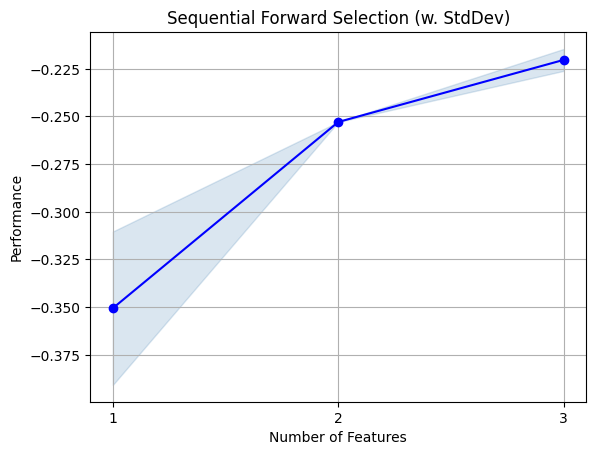

In [99]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [100]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7750eb9c68c0>),
                ('model', RandomForestClassifier())])

In [101]:
predictions_sfs = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_sfs, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_sfs, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_sfs, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/20 10:33:34 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:34 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: uninstalled, required: fastapi)
 - uvicorn (current: uninstalled, required: uvicorn)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/20 10:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://1

In [102]:
from sklearn.model_selection import  GridSearchCV

In [103]:
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

In [ ]:
from IPython.display import clear_output

In [112]:
gs = GridSearchCV(rfe_sfs_pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)
clear_output(wait='True')

In [ ]:
print("Лучшие гиперпараметры:", gs.best_params_)

Лучшие гиперпараметры: {'model__max_depth': 8, 'model__max_features': 0.8, 'model__n_estimators': 4}


In [ ]:
classifier_optimized = RandomForestClassifier(max_depth=7, max_features=0.9, n_estimators=4)

In [ ]:
rfe_skl_pipeline_optimised = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])
rfe_skl_pipeline_optimised.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7b4f0cd5bf70>),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=0.9,
                                        n_estimators=4))])

In [ ]:
predictions_gridSV = rfe_skl_pipeline_optimised.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions_gridSV, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_gridSV, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_gridSV, average='weighted')
metrics

{'precision': 0.885108845407785,
 'recall': 0.8739255014326648,
 'f1': 0.8754835436032584}

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection_optimised_GridSearchSV'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_skl_pipeline_optimised, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 15:41:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection_optimised_GridSearchSV at: http://127.0.0.1:5000/#/experiments/2/runs/4b4371f79e8a45f18c950c356def63db.
2024/11/19 15:41:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


In [115]:
import optuna

In [113]:
def objective(trial):
    # предлагаем гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 10, 200) # Количество деревьев
    max_depth = trial.suggest_int('max_depth', 1, 20) # Глубина деревьев
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # Доля признаков

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
        ))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    f1 =  f1_score(y_test, preds,  average='weighted')   

    return f1

In [116]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-20 10:54:06,018] A new study created in memory with name: no-name-eebb2eb6-eb67-4f4b-ba99-dd6d7008c040
[I 2024-11-20 10:54:06,593] Trial 0 finished with value: 0.7857056134088354 and parameters: {'n_estimators': 110, 'max_depth': 2, 'max_features': 0.16883920655972087}. Best is trial 0 with value: 0.7857056134088354.
[I 2024-11-20 10:54:07,079] Trial 1 finished with value: 0.8686813453958172 and parameters: {'n_estimators': 127, 'max_depth': 17, 'max_features': 0.23244172457550244}. Best is trial 0 with value: 0.7857056134088354.
[I 2024-11-20 10:54:07,632] Trial 2 finished with value: 0.8745842464641466 and parameters: {'n_estimators': 175, 'max_depth': 12, 'max_features': 0.6316834803098962}. Best is trial 0 with value: 0.7857056134088354.
[I 2024-11-20 10:54:07,924] Trial 3 finished with value: 0.880164598160347 and parameters: {'n_estimators': 100, 'max_depth': 7, 'max_features': 0.16871638760041302}. Best is trial 0 with value: 0.7857056134088354.
[I 2024-11-20 10:54:08

Number of finished trials: 10
Best trial: {'n_estimators': 104, 'max_depth': 1, 'max_features': 0.9166562778576015}


In [117]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier())
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7750dec63cd0>),
                ('model', RandomForestClassifier())])

In [ ]:
optuna_model = opt_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, optuna_model, average='weighted')   
metrics["recall"] = recall_score(y_test, optuna_model, average='weighted')
metrics["f1"] = f1_score(y_test, optuna_model, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 16:07:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/2/runs/6352a1d89f9b4eac8463e4c41959791a.
2024/11/19 16:07:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


In [ ]:
Y = df['target']
X = df.drop('target', axis=1)

In [ ]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['battery_power'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7b4f07bb8700>),
                ('model', RandomForestClassifier())])

In [ ]:
predictions_sfs = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_sfs, average='weighted')
metrics["recall"] = recall_score(y_test, predictions_sfs, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_sfs, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

{'precision': 0.9058798186142433,
 'recall': 0.9025787965616046,
 'f1': 0.9030920972173959}